In [1]:
# data_cleaning.ipynb (or extend your EDA.ipynb)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Import the cleaning and correlation functions
from src.data_preprocessing import (
    remove_outliers_below_threshold,
    resample_data,
    compute_correlations,
    get_top_correlations,
    fill_nans_with_previous_day,
    fill_nans_day_before_after_interpolate
)

In [2]:
# ========== 1. Load Data (if not already loaded) ==========
file_path = '../data/raw/LD2011_2014.txt'
df = pd.read_csv(
    file_path, 
    sep=';', 
    decimal=',', 
    index_col=0, 
    parse_dates=True
)

In [3]:
# ========== 2. Remove Outliers Below Threshold ==========
threshold = 1.0  # Example: anything below 1 kWh is considered invalid/outlier
df_clean = remove_outliers_below_threshold(df, threshold=threshold)

# ========== 3. Resample to 30-Minute Intervals ==========
# The dataset is originally at 15-minute intervals, 
# but let's confirm or re-aggregate to 30-minute.
df_30min = resample_data(df_clean, freq='30T', agg='mean')

c:\githubrepo\network-traffic-anomaly-detection\src\data_preprocessing.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(freq).mean()


In [4]:
# ========== 4. Check Correlation Across All Meters ==========
# corr_matrix = compute_correlations(df_30min)
# top_correlations = get_top_correlations(corr_matrix, top_n=50)
# print("Top 50 Correlated Meter Pairs:\n", top_correlations)

In [5]:
# # ========== 5. Verify Cleaning with Random Meters ==========
# # Let's pick 5 random meter columns from df_30min
# all_meters = list(df_30min.columns)
# random_meters = random.sample(all_meters, 5)

# # Time-series plots for random meters
# df_30min[random_meters].plot(subplots=True, figsize=(12, 10), layout=(3,2), sharex=True)
# plt.suptitle("Time Series of 5 Random Meters (After Cleaning & 30-min Resample)")
# plt.tight_layout()
# plt.show()

# # Histograms for random meters
# import math

# rows = math.ceil(len(random_meters) / 2)
# fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))
# axes = axes.flatten()

# for i, meter in enumerate(random_meters):
#     sns.histplot(df_30min[meter].dropna(), bins=50, kde=True, ax=axes[i])
#     axes[i].set_title(f"Distribution of {meter} (Cleaned)")
#     axes[i].set_xlabel("Consumption (kWh)")
#     axes[i].set_ylabel("Frequency")

# # Hide any extra subplots if random_meters < 10
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

In [6]:
def find_gaps_in_column(series):
    """
    Find intervals of NaNs in a single time-series (Pandas Series),
    considering only the range between the column's first and last valid data.
    
    Returns a list of (gap_start, gap_end) tuples.
    If the entire series is NaN, returns one interval covering the entire index.
    If there are no gaps, returns an empty list.
    """
    # Identify earliest and latest valid timestamps
    start = series.first_valid_index()
    end = series.last_valid_index()

    # If the entire column is NaN, we define one big "gap" over the entire index
    if start is None or end is None:
        if len(series) == 0:
            return []  # Empty series
        return [(series.index[0], series.index[-1])]  # Entirely NaN

    # Slice only between the column's local min and max valid dates
    sub = series.loc[start:end]

    # Create a mask for NaNs
    mask = sub.isna()

    # Use .diff() on the integer representation to find transitions
    transitions = mask.astype(int).diff()

    # Gap starts where diff == 1, ends where diff == -1
    gap_starts = sub.index[transitions == 1]
    gap_ends   = sub.index[transitions == -1]

    # If the sub starts with NaN
    if len(sub) > 0 and mask.iloc[0]:
        gap_starts = pd.Index([start]).append(gap_starts)
    # If the sub ends with NaN
    if len(sub) > 0 and mask.iloc[-1]:
        gap_ends = gap_ends.append(pd.Index([end]))

    # Pair up each gap_start with the corresponding gap_end
    intervals = list(zip(gap_starts, gap_ends))
    return intervals

import matplotlib.pyplot as plt
import random

def detect_and_plot_gaps(df, random_cols=5):
    """
    1. Randomly selects `random_cols` clients (columns).
    2. Finds the NaN gap intervals for each chosen client.
    3. For each client, creates a row of subplots – one for each gap.
       The total number of columns equals the maximum number of gaps found among the clients.
    4. In each subplot, a zoomed-in view is plotted with 2 days before the gap start
       and 2 days after the gap end.
    
    :param df: A DataFrame where each column is a client (meter),
               and the index is a DateTimeIndex.
    :param random_cols: Number of columns to sample for inspection.
    """
    # Pick random columns (clients)
    all_cols = df.columns.tolist()
    if random_cols > len(all_cols):
        random_cols = len(all_cols)
    chosen_cols = random.sample(all_cols, random_cols)

    # Dictionary to store gap intervals for each chosen client
    col_gap_intervals = {}

    # Identify gaps for each chosen client using find_gaps_in_column
    for col in chosen_cols:
        intervals = find_gaps_in_column(df[col])
        col_gap_intervals[col] = intervals

    # Determine maximum number of gaps found among selected clients
    n_max = max(len(intervals) for intervals in col_gap_intervals.values())
    if n_max == 0:
        print("no gaps detected for this group")
        return None

    # Create a grid of subplots: random_cols rows x n_max columns
    fig, axes = plt.subplots(random_cols, n_max, figsize=(5 * n_max, 3 * random_cols))

    # Ensure axes is 2D for uniform indexing
    if random_cols == 1:
        axes = np.atleast_2d(axes)
    if n_max == 1:
        axes = np.expand_dims(axes, axis=1)

    # Loop over each client (row) and each gap (column)
    for row_idx, col in enumerate(chosen_cols):
        series = df[col]
        intervals = col_gap_intervals[col]
        for col_idx in range(n_max):
            ax = axes[row_idx, col_idx]
            if col_idx < len(intervals):
                gap_start, gap_end = intervals[col_idx]
                # Define zoom window: 2 days before gap_start and 2 days after gap_end
                start_zoom = gap_start - pd.Timedelta(days=2)
                end_zoom = gap_end + pd.Timedelta(days=2)
                sub = series.loc[start_zoom:end_zoom]
                ax.plot(sub.index, sub, label=col, color='blue')
                ax.axvspan(gap_start, gap_end, color='red', alpha=0.3)
                ax.set_title(f"{col} - Gap {col_idx+1}")
                # Rotate the tick labels for clarity
                for label in ax.get_xticklabels():
                    label.set_rotation(45)
            else:
                ax.axis('off')  # Hide unused subplot
    plt.tight_layout()
    plt.show()


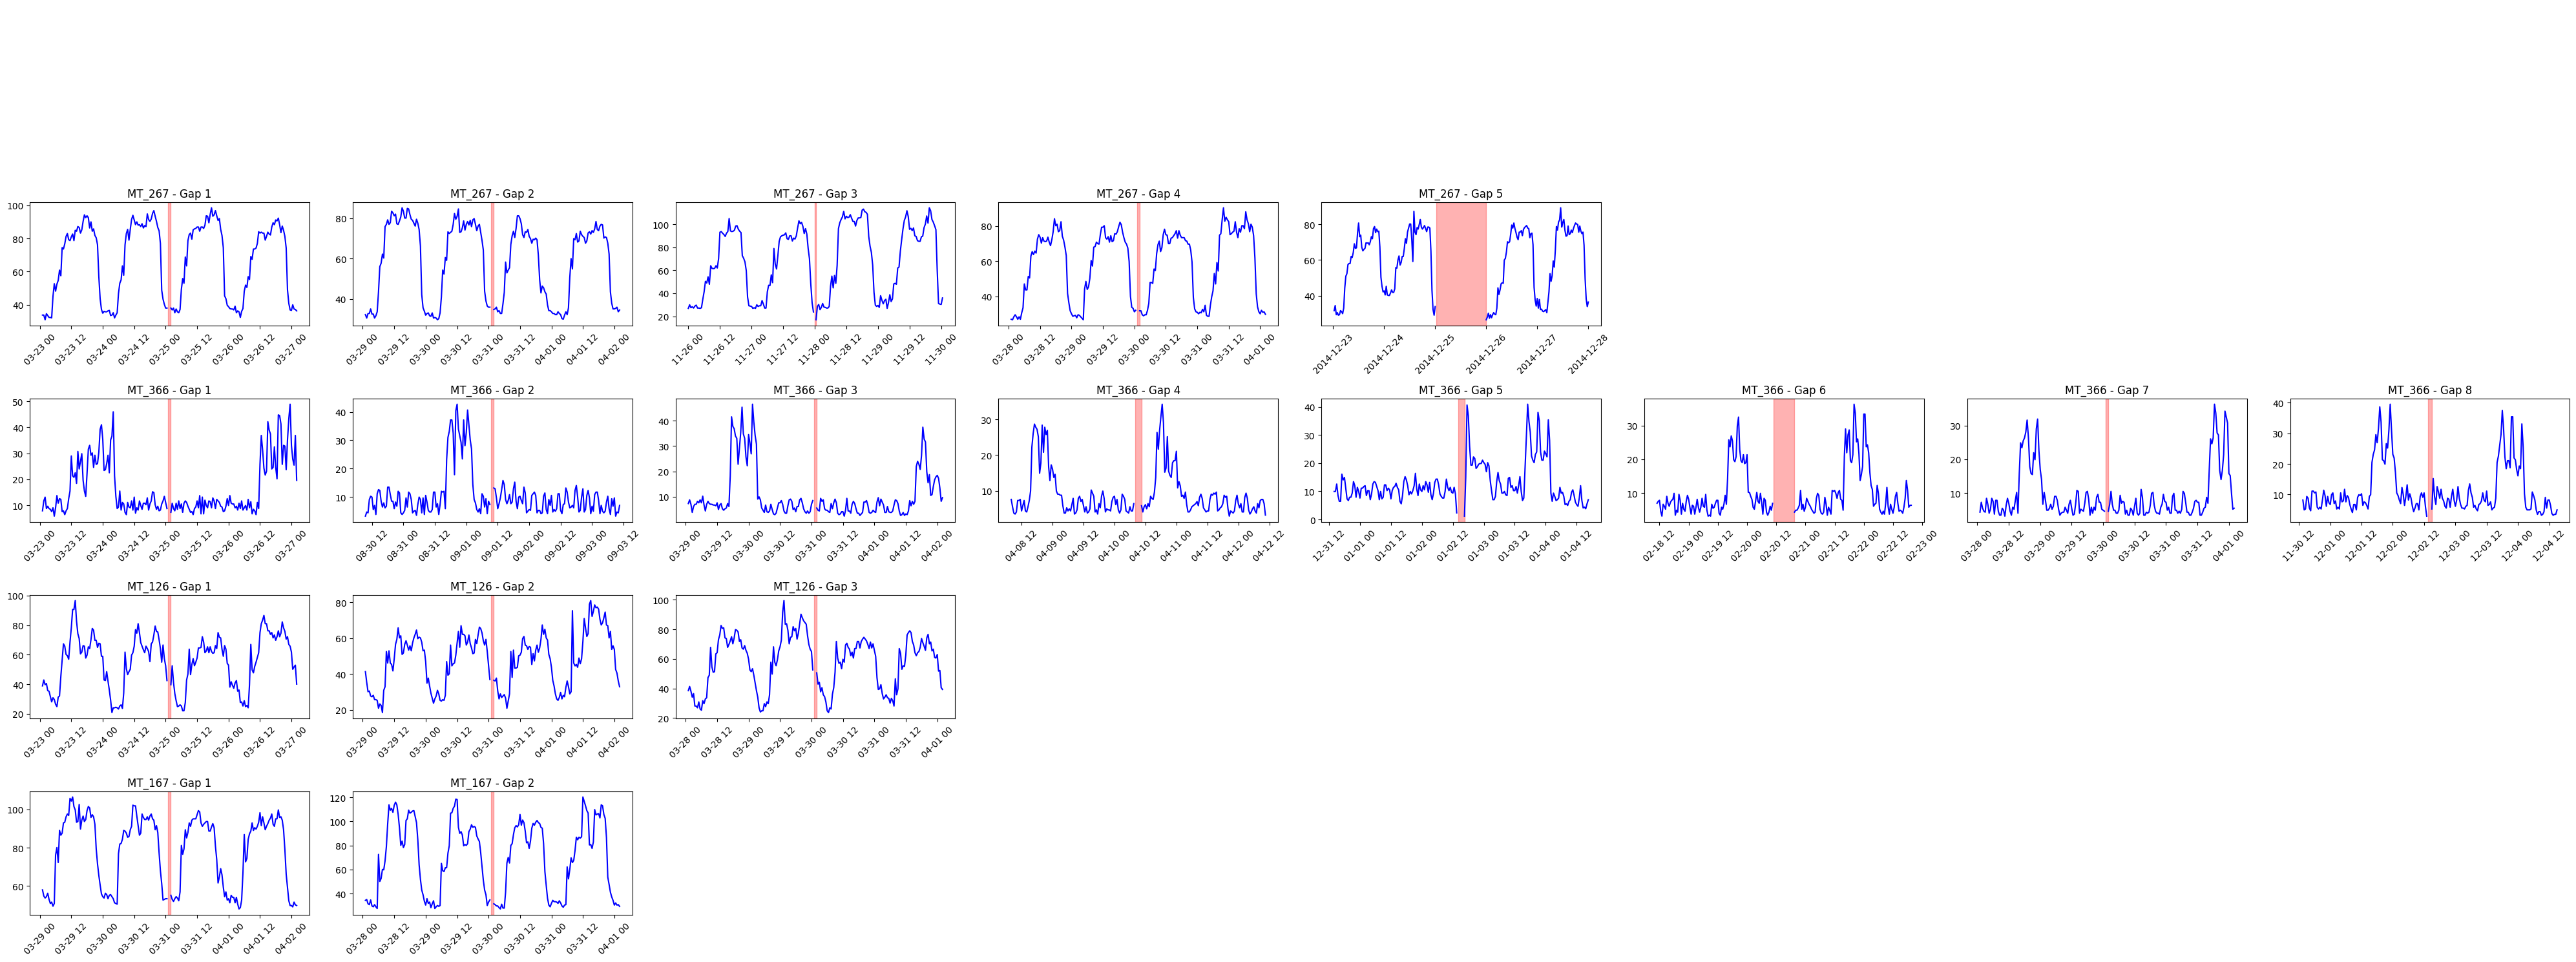

In [7]:
# Suppose 'df_30min' is your DataFrame after cleaning/resampling
detect_and_plot_gaps(df_30min, random_cols=5)

In [8]:
# ========== 1. Seasonal Fill ==========
df_temp = df_30min.copy()
for i in range(3):  # up to 3 passes
    new_filled = fill_nans_day_before_after_interpolate(df_30min, periods_per_day=48)
    # If no new NaNs were filled, we can break early
    if new_filled.equals(df_temp):
        break
    df_temp = new_filled
df_filled = df_temp

In [9]:
def verify_no_internal_gaps(df):
    """
    Checks if any column has NaNs between its first and last valid data point.
    Prints columns with gaps, or a success message if none.
    """# or inline that code
    
    columns_with_gaps = []
    for col in df.columns:
        intervals = find_gaps_in_column(df[col])
        if len(intervals) > 0:
            columns_with_gaps.append(col)

    if len(columns_with_gaps) == 0:
        print("No internal gaps detected for any client!")
    else:
        print("Columns with internal gaps:")
        for c in columns_with_gaps:
            print("  ", c)

# Example usage:
verify_no_internal_gaps(df_filled)


No internal gaps detected for any client!
